## Modeling ##

In [1]:
import time
import pickle
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import scipy.stats as stats
from numpy import interp
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV, 
    cross_val_score, 
    cross_val_predict
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    r2_score,
    mean_squared_error, 
    root_mean_squared_error,
    mean_absolute_error, 
    mean_absolute_percentage_error,
    accuracy_score,
    matthews_corrcoef,
    brier_score_loss,
    f1_score
)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [2]:
os.chdir('..')
print(f'Current working directory is {os.getcwd()}')

Current working directory is C:\Users\cavin\Documents\NSS_Projects\Python\big-g-big-rigs


This notebook is dedicated to the feature selection and statistical modeling of our trucking data.

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('data/data_clean_05_05.csv', low_memory=False)

Cleaning features and reassigning them to the proper dtypes

In [5]:
columns_to_object = ['ecuSource',
                     'spn',
                     'fmi',
                     'MCTNumber',
                     'RecordID',
                     'ESS_Id'
                    ]

for column in columns_to_object:
    df[column] = df[column].astype(object)

In [6]:
columns_to_bool = ['CruiseControlActive',
                   'IgnStatus',
                   'ParkingBrake']

for column in columns_to_bool:
    df[column] = df[column].astype(bool)

In [7]:
int64_cols = df.select_dtypes(include='bool').columns
df[int64_cols] = df[int64_cols].astype('int64')

Separating the test and training data.

In [8]:
test_date = '2019-01-01'

df_test = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] > test_date]

In [9]:
df_train = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] < test_date]

In [10]:
#df = df.sample(frac=0.50)

Scaling and encoding features for modeling.

In [11]:
X_train = df_train.drop(columns = [
            'target',  
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'ecuSerialNumber',
            'ecuSoftwareVersion',
            'time_derate',
            'time_until_derate',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ServiceDistance',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'MCTNumber',
            'EquipmentID',
            'LampStatus',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd'
            ], axis=1)

y_train = df_train['target']

In [12]:
X_test = df_test.drop(columns = [
            'target',  
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'ecuSerialNumber',
            'ecuSoftwareVersion',
            'time_derate',
            'time_until_derate',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ServiceDistance',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'MCTNumber',
            'EquipmentID',
            'LampStatus',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd'
            ], axis=1)

y_test = df_test['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, random_state = 27, train_size = 0.6/0.8)

Selection of features for each step of the pipeline. The last few lines are for checking to make sure each feature is accounted for.

In [13]:
ohe_features = ['spn',
                'fmi',
                'ecuSource'
                ] 

bool_features = ['CruiseControlActive',
                 'IgnStatus',
                 'ParkingBrake',
                 'active'
                ]

scale_features = ['AcceleratorPedal',
                  'BarometricPressure',
                  'EngineCoolantTemperature',
                  'EngineOilPressure',
                  'EngineOilTemperature',
                  'EngineRpm',
                  'FuelLevel',
                  'FuelLtd',
                  'FuelTemperature',
                  'IntakeManifoldTemperature',
                  'Speed',
                  'FuelRate',
                  'EngineTimeLtd',
                  'Throttle',
                  'activeTransitionCount'
                 ]

everything = list(set(ohe_features + bool_features + scale_features))
the_rest = X_train.columns.difference(everything)
pca = PCA(n_components = 5)

In [30]:
%%time

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ii', IterativeImputer(initial_strategy = 'mean',
                           max_iter = 30,
                           sample_posterior = True))
])

categorical_pipeline = Pipeline([
    ('ohe', OneHotEncoder(categories='auto', 
                          handle_unknown = 'ignore')),
    ('si', SimpleImputer(strategy = 'most_frequent'))
])

boolean_pipeline = Pipeline([
    ('ii', IterativeImputer(initial_strategy = 'most_frequent',
                           max_iter = 30,
                           sample_posterior = True))
])

ct = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, scale_features),
        ('cat', categorical_pipeline, ohe_features),
        ('bool', boolean_pipeline, bool_features)
    ],
    remainder='drop'
)

pipe = Pipeline(
    steps=[
        ('transformer', ct)
    ])

pipe.fit(X_train, y_train)

CPU times: total: 11min 13s
Wall time: 6min 16s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('ii',
                                                                   IterativeImputer(max_iter=30,
                                                                                    sample_posterior=True))]),
                                                  ['AcceleratorPedal',
                                                   'BarometricPressure',
                                                   'EngineCoolantTemperature',
                                                   'EngineOilPressure',
                                                   'EngineOilTemperature',
                                                   'EngineRpm', 'FuelLevel',
                                                   'FuelLtd', 'FuelTemperature',
                                                   'IntakeManif...
                                                   'activeTransitionCount']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('si',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['spn', 'fmi', 'ecuSource']),
                                                 ('bool',
                                                  Pipeline(steps=[('ii',
                                                                   IterativeImputer(initial_strategy='most_frequent',
                                                                                    max_iter=30,
                                                                                    sample_posterior=True))]),
                                                  ['CruiseControlActive',
                                                   'IgnStatus', 'ParkingBrake',
                                                   'active'])]))])

The above cell takes 11 minutes to fit the pipe, and the cell below takes 4 minutes to transform the pipe.

In [31]:
%%time

X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test) 

CPU times: total: 4min 48s
Wall time: 3min 3s


In [32]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

Transformation of pipe and saving the pipe as a pickle object so that the pipe doesn't need to be fitted again.

In [33]:
filename = 'pipe_transformed.pkl'

pickle_list = [pipe, X_train_balanced, X_test_transformed, y_train_balanced]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [34]:
filename = 'pipe_transformed.pkl'

with open(filename, 'rb') as file:
    pipe, X_train_balanced, X_test_transformed, y_train_balanced = pickle.load(file)

Applying the pipe transformations to models to see which model performs best.

%%time

knn_model = KNeighborsClassifier().fit(X_train_balanced, y_train_balanced)

%%time

y_pred_knn = knn_model.predict(X_test_transformed)

filename = 'knn.pkl'

pickle_list = [y_pred_knn, knn_model]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

filename = 'knn.pkl'

with open(filename, 'rb') as file:
    knn_model, y_pred_knn = pickle.load(file)

Prediction on KNeighborsClassifier takes a while

print(f'Accuracy: {accuracy_score(y_test, y_pred_knn)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_knn)}')
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, zero_division = 0))
#print(cross_val_score(knn_model, X_train_transformed, y_train, cv=3))

In [35]:
%%time

xgb = XGBClassifier(

    
).fit(X_train_balanced, y_train_balanced)

y_pred_xgb = xgb.predict(X_test_transformed)

CPU times: total: 2min 19s
Wall time: 13.4 s


In [36]:
filename = 'xgb.pkl'

pickle_list = [y_pred_xgb, xgb]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [37]:
filename = 'xgb.pkl'

with open(filename, 'rb') as file:
    y_pred_xgb, xgb = pickle.load(file)

In [38]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_xgb)}')
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, zero_division = 0))

Accuracy: 0.9881694486550484
MCC: 0.17897425234478154
[[110073   1190]
 [   129     99]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    111263
           1       0.08      0.43      0.13       228

    accuracy                           0.99    111491
   macro avg       0.54      0.71      0.56    111491
weighted avg       1.00      0.99      0.99    111491



In [39]:
probas = xgb.predict_proba(X_test_transformed)

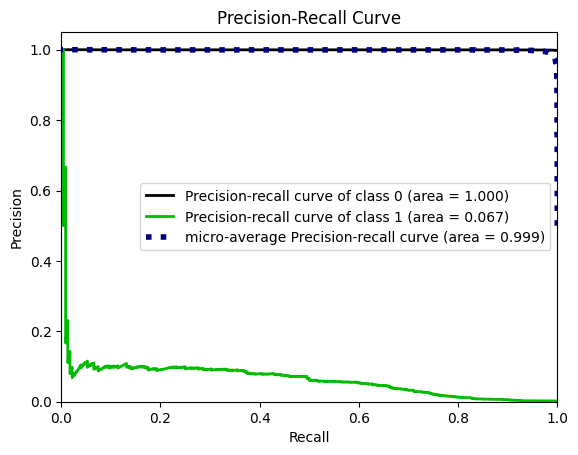

In [64]:
skplt.metrics.plot_precision_recall(y_test, probas)
plt.show()

In [73]:
df_test['predictions'] = y_pred_xgb
pred_df = df_test[['EventTimeStamp', 'EquipmentID', 'target', 'predictions']]
pred_df[(pred_df['target'] == 0) & (pred_df['predictions'] == 1)].drop_duplicates()

,EventTimeStamp,EquipmentID,target,predictions
945615,2019-01-01 07:24:05,1946,0,1
945857,2019-01-02 11:05:05,1953,0,1
946223,2019-01-03 14:52:43,1914,0,1
946328,2019-01-03 22:10:41,1791,0,1
946371,2019-01-04 06:10:03,1798,0,1
...,...,...,...,...
1056840,2020-03-05 21:00:31,2309,0,1
1056844,2020-03-05 21:20:15,2309,0,1
1056853,2020-03-06 02:42:32,2309,0,1
1057033,2020-03-06 13:07:34,1994,0,1


In [74]:
def target_pred(df, event, equipment, target, pred):
    df[event] = pd.to_datetime(df[event])
    df = df.sort_values(by=[equipment, event])
    df['time_diff'] = df.groupby(equipment)[event].diff().dt.total_seconds() / 3600
    df['valid_group'] = (df['time_diff'].isna()) | (df['time_diff'] <= 2)
    df['temp_group'] = (~df['valid_group']).cumsum()
    df['combined'] = df[target].astype(str) + '_' + df[pred].astype(str)
    
    result = df.groupby([equipment, 'temp_group'])['combined'].value_counts().reset_index(name='count')
    result = result.groupby(equipment)['combined'].value_counts().unstack(fill_value=0)
    result = result.rename(columns = {'0_0': 'true negative', '0_1': 'false positive', '1_0': 'false negative', '1_1': 'true positive'})
    
    return result

In [76]:
counts = target_pred(pred_df, 'EventTimeStamp', 'EquipmentID', 'target', 'predictions')

C:\Users\cavin\AppData\Local\Temp\ipykernel_65392\1487341804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[event] = pd.to_datetime(df[event])


In [87]:
TN = (counts.iloc[:,0].sum() * 0) 
FN = (counts.iloc[:,1].sum() * 500)
FP = (counts.iloc[:,2].sum() * 4000)
TP = (counts.iloc[:,3].sum() * 4000)

print(TN - FN - FP + TP)

-382500


In [41]:
%%time

rfc = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=27).fit(X_train_balanced, y_train_balanced)

y_pred_rfc = rfc.predict(X_test_transformed)

CPU times: total: 16.7 s
Wall time: 16.3 s


In [42]:
filename = 'rfc.pkl'

pickle_list = [y_pred_rfc, rfc]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [43]:
filename = 'rfc.pkl'

with open(filename, 'rb') as file:
    y_pred_rfc, rfc = pickle.load(file)

In [44]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_rfc)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_rfc)}')
print(confusion_matrix(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfc, zero_division = 0))

Accuracy: 0.8605358280040541
MCC: 0.06979193984196924
[[95788 15475]
 [   74   154]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    111263
           1       0.01      0.68      0.02       228

    accuracy                           0.86    111491
   macro avg       0.50      0.77      0.47    111491
weighted avg       1.00      0.86      0.92    111491



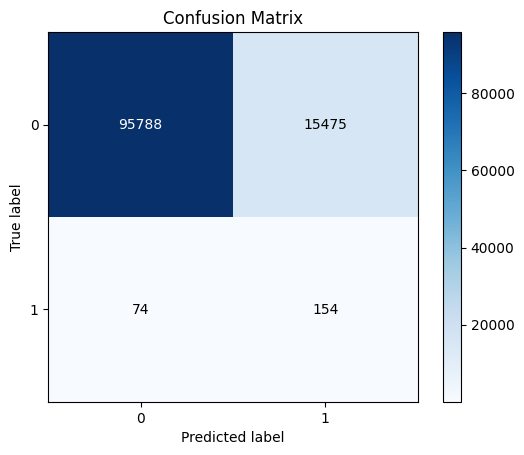

In [45]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rfc, normalize=False)
plt.show()

In [46]:
%%time

logreg = LogisticRegression(max_iter=10000).fit(X_train_balanced, y_train_balanced)

y_pred_logreg = logreg.predict(X_test_transformed)

CPU times: total: 1min 14s
Wall time: 1min 14s


In [47]:
filename = 'logreg.pkl'

pickle_list = [y_pred_logreg, logreg]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [48]:
filename = 'logreg.pkl'

with open(filename, 'rb') as file:
    y_pred_logreg, logreg = pickle.load(file)

In [49]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_logreg)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_logreg)}')
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg, zero_division = 0))

Accuracy: 0.7669767066399978
MCC: 0.06539939566585373
[[85318 25945]
 [   35   193]]
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    111263
           1       0.01      0.85      0.01       228

    accuracy                           0.77    111491
   macro avg       0.50      0.81      0.44    111491
weighted avg       1.00      0.77      0.87    111491



In [50]:
df_test['predictions'] = y_pred_logreg

In [51]:
pred_df = df_test[['EventTimeStamp', 'EquipmentID', 'spn', 'target', 'predictions']]

In [52]:
pred_df[(pred_df['target'] == 1) & (pred_df['predictions'] == 1)].drop_duplicates()

,EventTimeStamp,EquipmentID,spn,target,predictions
949513,2019-01-13 11:58:11,1698,4340,1,1
949512,2019-01-13 11:58:11,1698,6802,1,1
949526,2019-01-13 13:13:23,1698,1569,1,1
949690,2019-01-14 07:14:09,1698,111,1,1
952402,2019-01-21 03:54:10,1827,1569,1,1
...,...,...,...,...,...
1052159,2020-02-13 08:32:46,1872,5743,1,1
1052160,2020-02-13 08:32:46,1872,1569,1,1
1052158,2020-02-13 08:32:46,1872,3364,1,1
1052161,2020-02-13 08:32:46,1872,1761,1,1


y_val_pred_proba = pipe.predict_proba(X_val)[:,1]

candidate_thresholds = np.arange(start = 0.1, stop = 0.925, step = 0.01)
thresholds = pd.DataFrame({'threshold': candidate_thresholds})
thresholds['f1'] = thresholds['threshold'].apply(lambda x: f1_score(y_val, y_val_pred_proba > x))
thresholds.sort_values('f1', ascending = False).head()

threshold = 0.10

y_pred_proba = model.predict_proba(X_test_transformed)[:,1]

y_pred = y_pred_proba > threshold
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [53]:
#param_grid = {
#    'preprocessor__num__scaler__with_mean': [True, False],
#    'preprocessor__num__scaler__with_std': [True, False],
#    'classifier__C': [0.1, 1, 10],
#    'classifier__solver': ['liblinear', 'newton-cg']
#}

#randomized_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=3)

%%time

hgbc = HistGradientBoostingClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_hgbc = hgbc.predict(X_test_transformed)

confusion_matrix(y_test, y_pred_hgbc)

print(classification_report(y_test, y_pred_hgbc, zero_division = 0))

In [54]:
%%time

dtc = DecisionTreeClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_dtc = dtc.predict(X_test_transformed)

CPU times: total: 12min 19s
Wall time: 12min 22s


In [55]:
filename = 'dtc.pkl'

pickle_list = [y_pred_dtc, dtc]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [56]:
filename = 'dtc.pkl'

with open(filename, 'rb') as file:
    y_pred_dtc, dtc = pickle.load(file)

In [57]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_dtc)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_dtc)}')
print(confusion_matrix(y_test, y_pred_dtc))
print(classification_report(y_test, y_pred_dtc, zero_division = 0))

Accuracy: 0.9949502650438152
MCC: 0.06270596078515554
[[110909    354]
 [   209     19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111263
           1       0.05      0.08      0.06       228

    accuracy                           0.99    111491
   macro avg       0.52      0.54      0.53    111491
weighted avg       1.00      0.99      1.00    111491



%%time

svm = SVC(kernel='linear', C=1.0, gamma='auto', probability=True)

svm.fit(X_train_balanced, y_train_balanced)

y_pred_svm = svm.predict(X_test_transformed)

filename = 'svm.pkl'

pickle_list = [y_pred_svm, svm]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

filename = 'svm.pkl'

with open(filename, 'rb') as file:
    y_pred_svm, svm = pickle.load(file)

print(f'Accuracy: {accuracy_score(y_test, y_pred_svm)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_svm)}')
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division = 0))

In [58]:
%%time

lgb = LGBMClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_lgb = lgb.predict(X_test_transformed)

[LightGBM] [Info] Number of positive: 944171, number of negative: 944171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.857562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25719
[LightGBM] [Info] Number of data points in the train set: 1888342, number of used features: 319
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: total: 1min 55s
Wall time: 16.7 s


C:\Users\cavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [59]:
filename = 'lgb.pkl'

pickle_list = [y_pred_lgb, lgb]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [60]:
filename = 'lgb.pkl'

with open(filename, 'rb') as file:
    y_pred_lgb, lgb = pickle.load(file)

In [61]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_lgb)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_lgb)}')
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb, zero_division = 0))

Accuracy: 0.9781058560780691
MCC: 0.19753440494475605
[[108897   2366]
 [    75    153]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    111263
           1       0.06      0.67      0.11       228

    accuracy                           0.98    111491
   macro avg       0.53      0.82      0.55    111491
weighted avg       1.00      0.98      0.99    111491



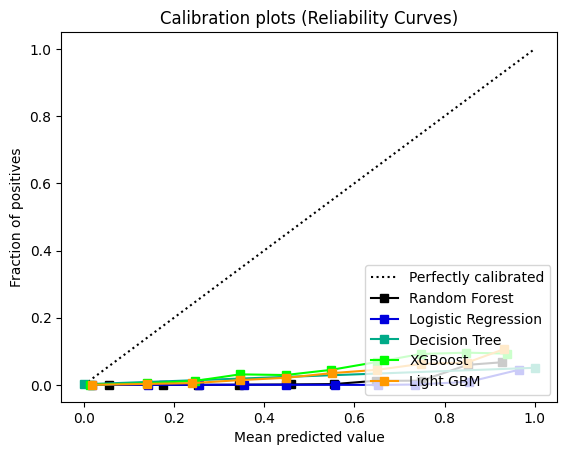

CPU times: total: 3.69 s
Wall time: 823 ms


In [63]:
%%time

rf_probas = rfc.predict_proba(X_test_transformed)
lr_probas = logreg.predict_proba(X_test_transformed)
dtc_probas = dtc.predict_proba(X_test_transformed)
xgb_probas = xgb.predict_proba(X_test_transformed)
lgb_probas = lgb.predict_proba(X_test_transformed)
probas_list = [rf_probas, 
               lr_probas, 
               dtc_probas, 
               xgb_probas, 
               lgb_probas]
clf_names = ['Random Forest', 
             'Logistic Regression',
             'Decision Tree', 
             'XGBoost',
             'Light GBM']
skplt.metrics.plot_calibration_curve(y_test,
                                     probas_list,
                                     clf_names)
plt.show()